In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
df = pd.read_csv('weather_data.csv')

In [3]:
df = pd.DataFrame(df)

In [4]:
df.head(5)

,time,temp,wind_speed,wind_degree,pressure,precip,humidity,cloud,uv,weather
0,2024-10-22 00:00,26.1,7.9,179,29.86,0.0,74,35,0.0,1003
1,2024-10-22 01:00,26.0,7.2,188,29.85,0.0,74,32,0.0,1003
2,2024-10-22 02:00,25.8,6.1,185,29.84,0.0,73,26,0.0,1003
3,2024-10-22 03:00,25.5,6.5,168,29.84,0.0,73,34,0.0,1003
4,2024-10-22 04:00,25.5,6.1,183,29.85,0.0,72,20,0.0,1000


In [5]:
df.duplicated().sum()

0

In [37]:
training = df.drop(['time', 'weather', 'precip', 'uv'], axis=1)

In [38]:
training.head(5)

,temp,wind_speed,wind_degree,pressure,humidity,cloud
0,26.1,7.9,179,29.86,74,35
1,26.0,7.2,188,29.85,74,32
2,25.8,6.1,185,29.84,73,26
3,25.5,6.5,168,29.84,73,34
4,25.5,6.1,183,29.85,72,20


In [39]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(training)

In [40]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# train_scaled = scaler.fit_transform(training)

In [41]:
pd.DataFrame(train_scaled).head(5)

,0,1,2,3,4,5
0,0.272,0.378788,0.500000,0.807692,0.637931,0.35
1,0.264,0.343434,0.525140,0.769231,0.637931,0.32
2,0.248,0.287879,0.516760,0.730769,0.620690,0.26
3,0.224,0.308081,0.469274,0.730769,0.620690,0.34
4,0.224,0.287879,0.511173,0.769231,0.603448,0.20


In [42]:
def create_sequences(data, sequence_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_horizon):
        X.append(data[i:i + sequence_length, :])
        y.append(data[i + sequence_length:i + sequence_length + forecast_horizon, :])
        
    return np.array(X), np.array(y)

In [43]:
sequence_length = 5
forecast_horizon = 1

X, y = create_sequences(train_scaled, sequence_length, forecast_horizon)

In [44]:
split_ratio = 0.9
split = int(split_ratio * len(X))

x_train, x_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [116]:
num_features = X.shape[2]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(sequence_length, num_features)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True)),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation='tanh', return_sequences=True)),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='tanh', return_sequences=False)),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_features * forecast_horizon),
    tf.keras.layers.Reshape((forecast_horizon, num_features))
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae'])

In [117]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 5, 256)           138240    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 5, 128)           123648    
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_35 (Dense)            (None, 128)               8320      
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                     

In [118]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=16, verbose=1)

Epoch 1/50
43/43 [==============================] - 18s 69ms/step - loss: 0.0656 - accuracy: 0.3518 - mae: 0.1992 - val_loss: 0.0358 - val_accuracy: 0.1688 - val_mae: 0.1557
Epoch 2/50
43/43 [==============================] - 1s 13ms/step - loss: 0.0241 - accuracy: 0.5737 - mae: 0.1208 - val_loss: 0.0232 - val_accuracy: 0.6883 - val_mae: 0.1151
Epoch 3/50
43/43 [==============================] - 1s 25ms/step - loss: 0.0190 - accuracy: 0.5869 - mae: 0.1035 - val_loss: 0.0208 - val_accuracy: 0.6234 - val_mae: 0.1068
Epoch 4/50
43/43 [==============================] - 1s 16ms/step - loss: 0.0160 - accuracy: 0.6569 - mae: 0.0928 - val_loss: 0.0161 - val_accuracy: 0.7013 - val_mae: 0.0926
Epoch 5/50
43/43 [==============================] - 1s 18ms/step - loss: 0.0145 - accuracy: 0.6511 - mae: 0.0868 - val_loss: 0.0144 - val_accuracy: 0.7143 - val_mae: 0.0848
Epoch 6/50
43/43 [==============================] - 1s 16ms/step - loss: 0.0131 - accuracy: 0.6526 - mae: 0.0811 - val_loss: 0.0165 - 

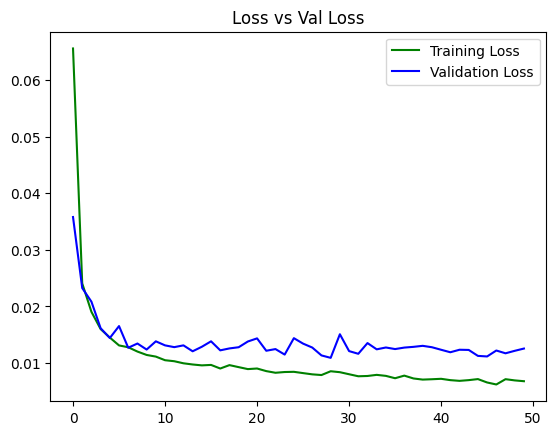

In [119]:
plt.plot(history.history['loss'], color='g', label='Training Loss')
plt.plot(history.history['val_loss'], color='b', label='Validation Loss')
plt.title("Loss vs Val Loss")
plt.legend()
plt.show()

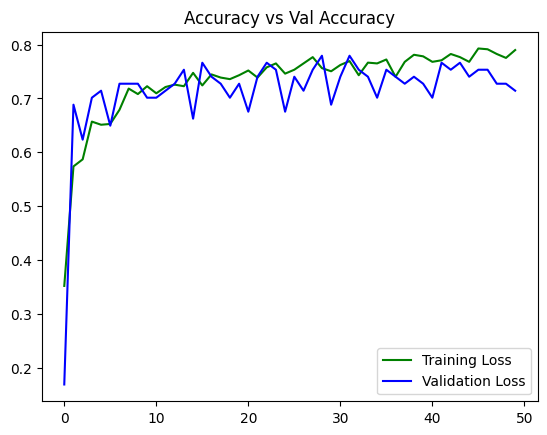

In [120]:
plt.plot(history.history['accuracy'], color='g', label='Training Loss')
plt.plot(history.history['val_accuracy'], color='b', label='Validation Loss')
plt.title("Accuracy vs Val Accuracy")
plt.legend()
plt.show()

In [121]:
loss, accuracy, mae = model.evaluate(x_test, y_test, verbose=0)
print("Loss : {}, MAE : {}, Validation Accuracy : {}".format(loss, mae, accuracy))

Loss : 0.012540275231003761, MAE : 0.0686318427324295, Validation Accuracy : 0.7142857313156128


In [122]:
predictions = model.predict(x_test)

print(scaler.inverse_transform(predictions[0]))
print(scaler.inverse_transform(y_test[0]))

3/3 [==============================] - 3s 6ms/step
[[27.568584  8.391356 62.361732 29.729633 67.19436  70.358894]]
[[27.4   7.2  52.   29.73 71.   71.  ]]


In [123]:
# model.save('forecasting.h5')